In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_csv('GOOG-year.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800
...,...,...,...,...,...,...,...
247,2017-10-26,980.000000,987.599976,972.200012,972.559998,972.559998,2042100
248,2017-10-27,1009.190002,1048.390015,1008.200012,1019.270020,1019.270020,5167700
249,2017-10-30,1014.000000,1024.969971,1007.500000,1017.109985,1017.109985,2085100
250,2017-10-31,1015.219971,1024.000000,1010.419983,1016.640015,1016.640015,1330700


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [4]:
train_dates = pd.to_datetime(df['Date'])

In [5]:
print(train_dates.tail(15)) #Check last few dates. 

237   2017-10-12
238   2017-10-13
239   2017-10-16
240   2017-10-17
241   2017-10-18
242   2017-10-19
243   2017-10-20
244   2017-10-23
245   2017-10-24
246   2017-10-25
247   2017-10-26
248   2017-10-27
249   2017-10-30
250   2017-10-31
251   2017-11-01
Name: Date, dtype: datetime64[ns]


In [6]:
cols = list(df)[1:6]

In [7]:
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [8]:
df_for_training = df[cols].astype(float)

In [55]:
df_for_training.tail(30)

,Open,High,Low,Close,Adj Close
222,933.000000,936.530029,923.830017,932.450012,932.450012
223,927.750000,934.729980,926.479980,928.530029,928.530029
224,925.450012,926.400024,909.700012,920.969971,920.969971
225,923.719971,930.820007,921.140015,924.859985,924.859985
226,927.739990,949.900024,927.739990,944.489990,944.489990
227,941.359985,950.690002,940.549988,949.500000,949.500000
228,952.000000,959.786011,951.510010,959.109985,959.109985
229,959.979980,962.539978,947.840027,953.270020,953.270020
230,954.000000,958.000000,949.140015,957.789978,957.789978
231,957.000000,960.390015,950.690002,951.679993,951.679993


In [77]:
df_for_training.shape[1]

5

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [28]:
trainX = []
trainY = []

n_future = 7   # Number of days we want to look into the future based on the past days.
n_past = 90  # Number of past days we want to use to predict the future.

In [29]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    

In [30]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (156, 90, 5).
trainY shape == (156, 1).


In [31]:
trainY[:5]

array([[-0.78231578],
       [-0.79470476],
       [-0.97152028],
       [-0.7902614 ],
       [-0.72844969]])

In [32]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

In [33]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 64)            17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
9/9 [==============================] - 3s 114ms/step - loss: 0.4179 - val_loss: 0.1982
Epoch 2/5
9/9 [==============================] - 0s 44ms/step - loss: 0.2517 - val_loss: 0.5547
Epoch 3/5
9/9 [==============================] - 0s 44ms/step - loss: 15294.1748 - val_loss: 0.5610
Epoch 4/5
9/9 [==============================] - 0s 46ms/step - loss: 1794966.1250 - val_loss: 0.6626
Epoch 5/5
9/9 [==============================] - 0s 45ms/step - loss: 236490176.0000 - val_loss: 0.8375


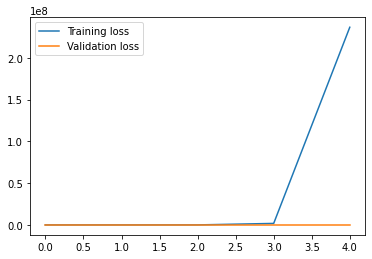

In [35]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [64]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 1
n_days_for_prediction=7  #let us predict past 15 days

In [65]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
predict_period_dates

[Timestamp('2017-11-01 00:00:00', freq='C'),
 Timestamp('2017-11-02 00:00:00', freq='C'),
 Timestamp('2017-11-03 00:00:00', freq='C'),
 Timestamp('2017-11-06 00:00:00', freq='C'),
 Timestamp('2017-11-07 00:00:00', freq='C'),
 Timestamp('2017-11-08 00:00:00', freq='C'),
 Timestamp('2017-11-09 00:00:00', freq='C')]

In [66]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
#prediction = model.predict(trainX[-7:])

In [67]:
prediction

array([[0.6693491 ],
       [0.7052444 ],
       [0.7391304 ],
       [0.77048063],
       [0.79438305],
       [0.81510794],
       [0.8257923 ]], dtype=float32)

In [68]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform copy same value to next founr columns
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
print(prediction_copies)


[[0.6693491  0.6693491  0.6693491  0.6693491  0.6693491 ]
 [0.7052444  0.7052444  0.7052444  0.7052444  0.7052444 ]
 [0.7391304  0.7391304  0.7391304  0.7391304  0.7391304 ]
 [0.77048063 0.77048063 0.77048063 0.77048063 0.77048063]
 [0.79438305 0.79438305 0.79438305 0.79438305 0.79438305]
 [0.81510794 0.81510794 0.81510794 0.81510794 0.81510794]
 [0.8257923  0.8257923  0.8257923  0.8257923  0.8257923 ]]


In [69]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

[928.79803 931.46356 933.97986 936.30786 938.0828  939.6218  940.4152 ]


In [70]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date()) 


In [71]:
forecast_dates

[datetime.date(2017, 11, 1),
 datetime.date(2017, 11, 2),
 datetime.date(2017, 11, 3),
 datetime.date(2017, 11, 6),
 datetime.date(2017, 11, 7),
 datetime.date(2017, 11, 8),
 datetime.date(2017, 11, 9)]

In [72]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [73]:
df_forecast

,Date,Open
0,2017-11-01,928.798035
1,2017-11-02,931.463562
2,2017-11-03,933.979858
3,2017-11-06,936.307861
4,2017-11-07,938.082825
5,2017-11-08,939.621826
6,2017-11-09,940.415222


C:\Users\zi1154\AppData\Local\Temp/ipykernel_13240/2860349802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
C:\Users\zi1154\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\zi1154\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: Future

<AxesSubplot:xlabel='Date', ylabel='Open'>

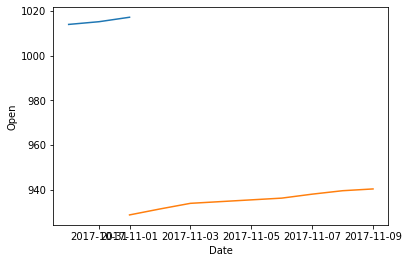

In [74]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2017-10-30']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])
